In [1]:
import cv2
import os
import json
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 엉망진창 EDA
## 이미지에 배경이 얼마나 차지할까?

In [4]:
#input image path
gt_image_path = '/opt/ml/lab/mmsegmentation/dataset/annotations/train'
og_image_path = '/opt/ml/lab/mmsegmentation/dataset/images/train'

# only extract extension png
file_list = [i for i in os.listdir(gt_image_path) if i.endswith('.png')]
print(len(file_list))

2617


In [10]:
#train(valid 는 빠짐) data 의 모든 정보를 dict로 변환
total_info = dict()

for item in tqdm(file_list):
    image= cv2.imread(gt_image_path+'/'+item)
    classes, counts = np.unique(image, return_counts=True)
    total_info[item] = dict(zip(classes, counts))

print(len(total_info))

100%|██████████| 2617/2617 [00:39<00:00, 65.91it/s]2617



In [12]:
total_mean = [total_info[k][0] / sum(v.values()) for k,v in total_info.items()]
outliner = []

for k,v in total_info.items():
    if total_info[k][0] / sum(v.values()) >= 0.9:
        outliner.append(k)

print(len(outliner))

208


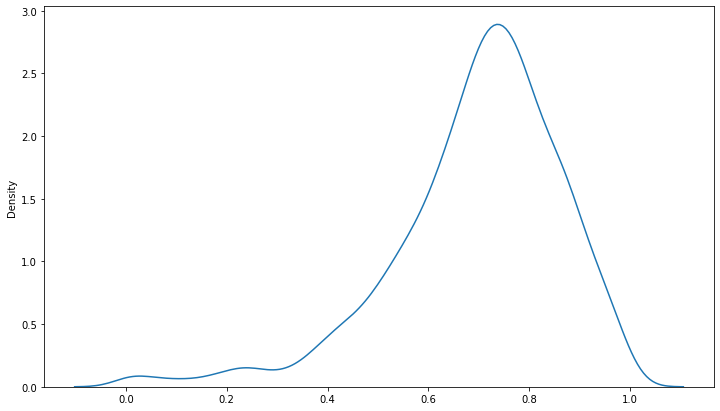

In [16]:
to_graph = sorted(total_mean)
fig, ax = plt.subplots(figsize=(12, 7))
sns.kdeplot(data=np.array(to_graph))
plt.show()

In [48]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]
# for image numbers
helper = 0

### visualize threshhold images

100%|██████████| 10/10 [00:00<00:00, 20.73it/s]


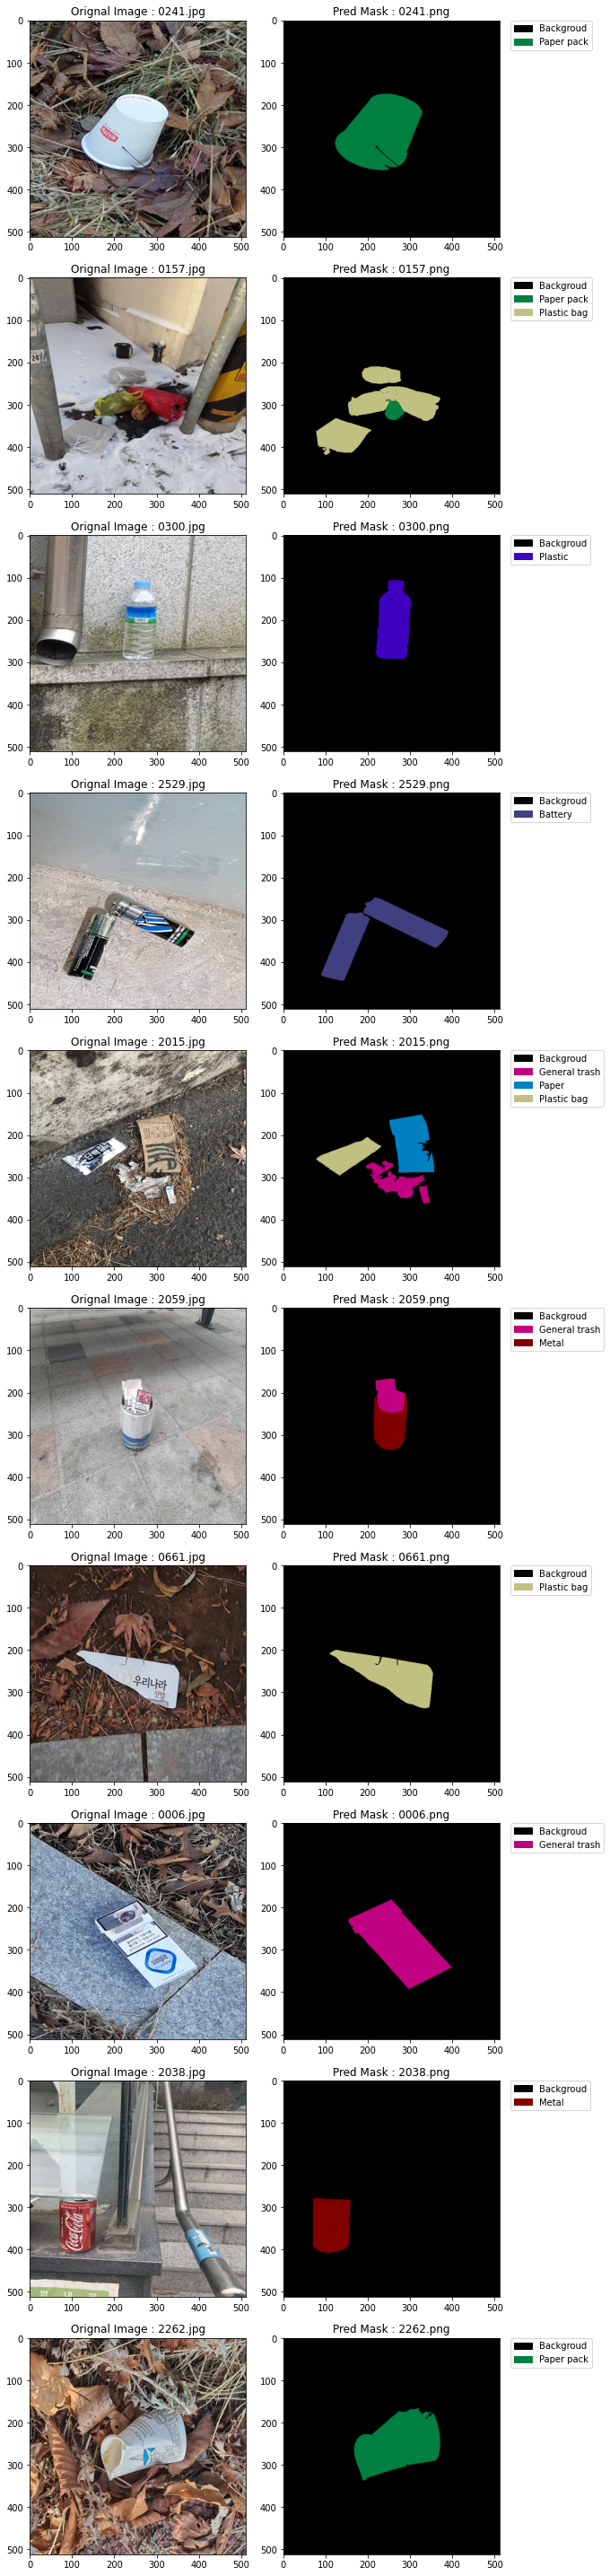

In [59]:
from matplotlib.patches import Patch
import webcolors

num_examples = 10 # 뽑아낼 image 개수
num_cols = 2 # Original | Prediction
class_colormap = pd.read_csv("class_dict.csv")

def make_elements(pred_cate):
    # variable for legend
    # pred_class를 나타내는 legend를 만들어 줍니다.
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values) if idx in pred_cate]

    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                                edgecolor=webcolors.rgb_to_hex(rgb), 
                                label=category) for category, rgb in category_and_rgb]

    return legend_elements

# plot
fig, ax = plt.subplots(nrows=num_examples, ncols=num_cols, figsize=(4*num_cols, 4*num_examples), constrained_layout=True)
fig.tight_layout()

for idx in tqdm(range(helper*num_examples, (helper+1)*num_examples)):

    file_name, _ = outliner[idx].split('.')

    original_img = cv2.imread(og_image_path+'/'+file_name+'.jpg')
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    gt_img = cv2.imread(gt_image_path+'/'+outliner[idx])
    gt_img = cv2.split(gt_img)

    # Original Image
    ax[idx-helper*num_examples][0].imshow(original_img)
    ax[idx-helper*num_examples][0].set_title(f"Orignal Image : {file_name+'.jpg'}")
    
    # Pred Mask
    ax[idx-helper*num_examples][1].imshow(label_to_color_image(gt_img[0]))
    ax[idx-helper*num_examples][1].set_title(f"Pred Mask : {outliner[idx]}")

    # Pred Class
    ax[idx-helper*num_examples][1].legend(handles=make_elements(total_info[outliner[idx]].keys()), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

helper+=1
plt.show()